<a href="https://colab.research.google.com/github/antoniodragoc/Projeto-de-Graduacao-Antonio-Drago-Caetano/blob/main/3_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
# import the needed packages
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import os

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import Xception

from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Conv2D

import seaborn as sns

import pandas as pd

from fast_ml.model_development import train_valid_test_split
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [83]:
#create an empty DataFrame
df = pd.DataFrame(columns=['path','label'])

#loop over fire images and label them 1
for dirname, _, filenames in os.walk('D:/Users/N30090/OneDrive - ArcelorMittal/Pictures/Doutorado_img/dados_aimonino+fetuga+lunadei_unet/BI_Benignas_BBOBMO_PWBHEPL_Aimonino+Fetuga+Lunadei/'):
    for filename in filenames:
        df1 = pd.DataFrame([[os.path.join(dirname, filename),'Benignas']],columns=['path','label'])
        df = pd.concat([df, df1], ignore_index=True)
#loop over non fire images and label them 0
for dirname, _, filenames in os.walk('D:/Users/N30090/OneDrive - ArcelorMittal/Pictures/Doutorado_img/dados_aimonino+fetuga+lunadei_unet/BI_Malignas_BBOBMO_PWBHEPL_Aimonino+Fetuga+Lunadei/'):
    for filename in filenames:
        df2 = pd.DataFrame([[os.path.join(dirname, filename),'Malignas']],columns=['path','label'])
        df = pd.concat([df, df2], ignore_index=True)
#shuffle the dataset for redistribute the labels
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

,path,label
0,D:/Users/N30090/OneDrive - ArcelorMittal/Pictu...,Malignas
1,D:/Users/N30090/OneDrive - ArcelorMittal/Pictu...,Malignas
2,D:/Users/N30090/OneDrive - ArcelorMittal/Pictu...,Malignas
3,D:/Users/N30090/OneDrive - ArcelorMittal/Pictu...,Malignas
4,D:/Users/N30090/OneDrive - ArcelorMittal/Pictu...,Malignas
5,D:/Users/N30090/OneDrive - ArcelorMittal/Pictu...,Malignas
6,D:/Users/N30090/OneDrive - ArcelorMittal/Pictu...,Benignas
7,D:/Users/N30090/OneDrive - ArcelorMittal/Pictu...,Benignas
8,D:/Users/N30090/OneDrive - ArcelorMittal/Pictu...,Benignas
9,D:/Users/N30090/OneDrive - ArcelorMittal/Pictu...,Malignas


In [84]:
fig = px.scatter(data_frame = df,x=df.index,y='label',color='label',title='Distribution of Benignas and Malignas images along the length of the dataframe')
fig.update_traces(marker_size=2)

In [85]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "xy"}, {"type": "pie"}]])


fig.add_trace(go.Bar(x =df['label'].value_counts().index,y=df['label'].value_counts().to_numpy(),marker_color=['darkorange','green'],showlegend=False),row=1,col=1)

fig.add_trace(go.Pie(
     values=df['label'].value_counts().to_numpy(),
     labels=df['label'].value_counts().index,
    marker=dict(colors=['darkorange','green'])),
    row=1, col=2)

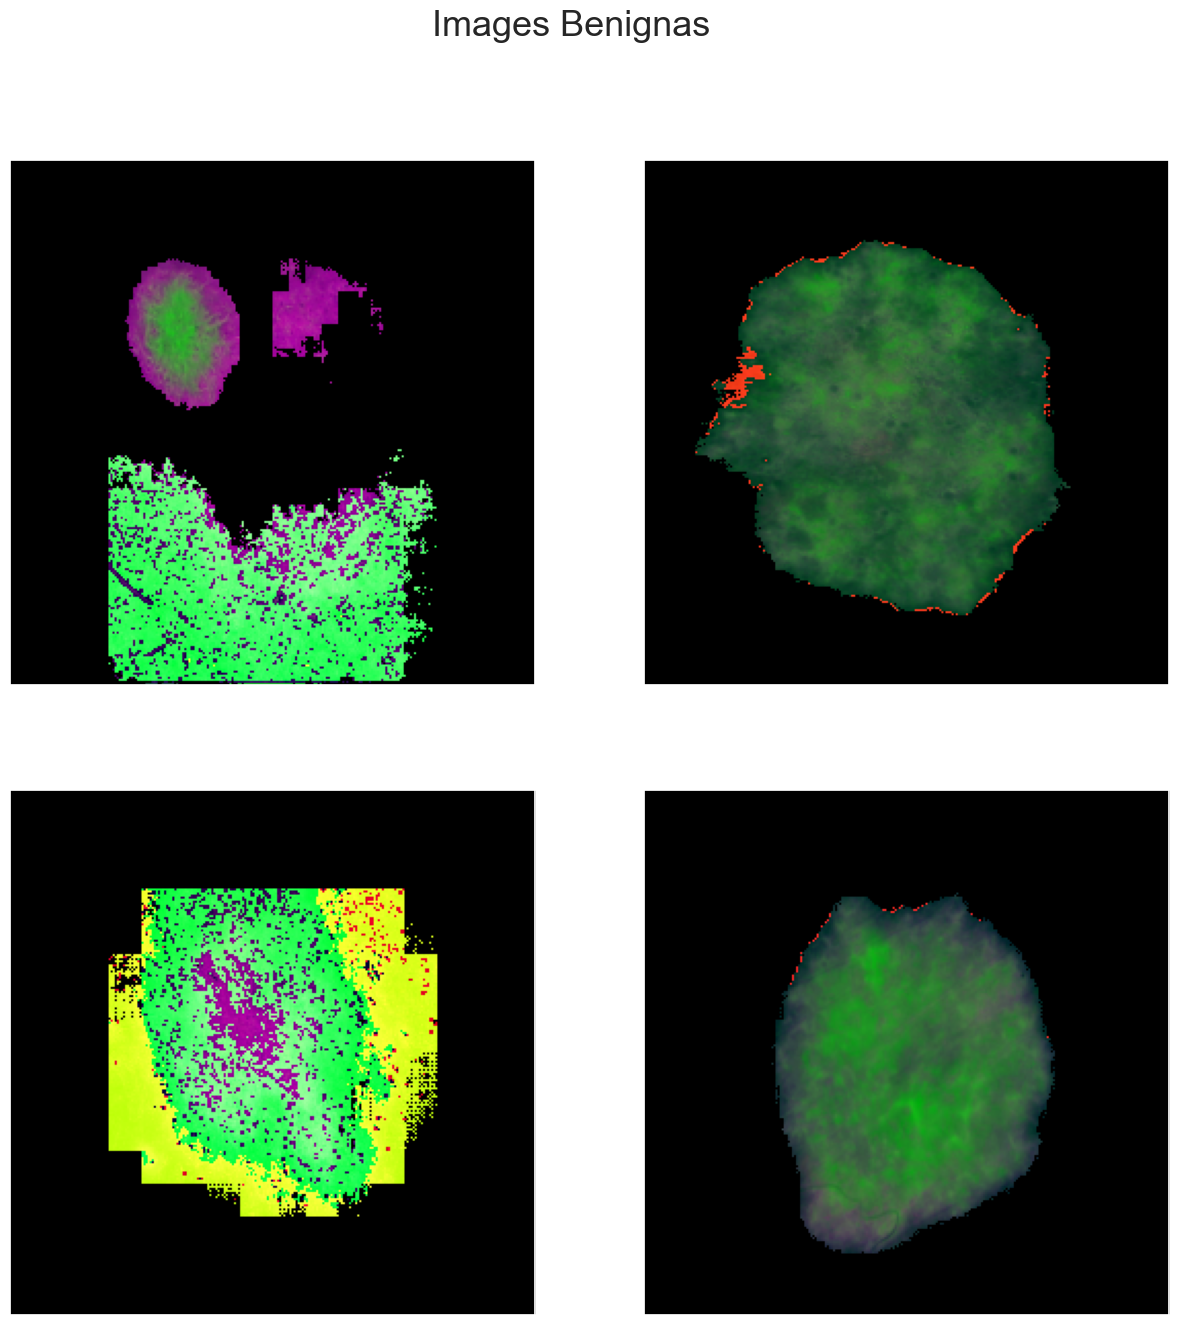

In [86]:
label = 'Benignas' #label for images with fire
data = df[df['label'] == label]

pics = 4 #set the number of pics
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Images Benignas')
ax = ax.ravel()
for i in range((pics//2)*2):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    img = image.load_img(path)
    img = image.img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

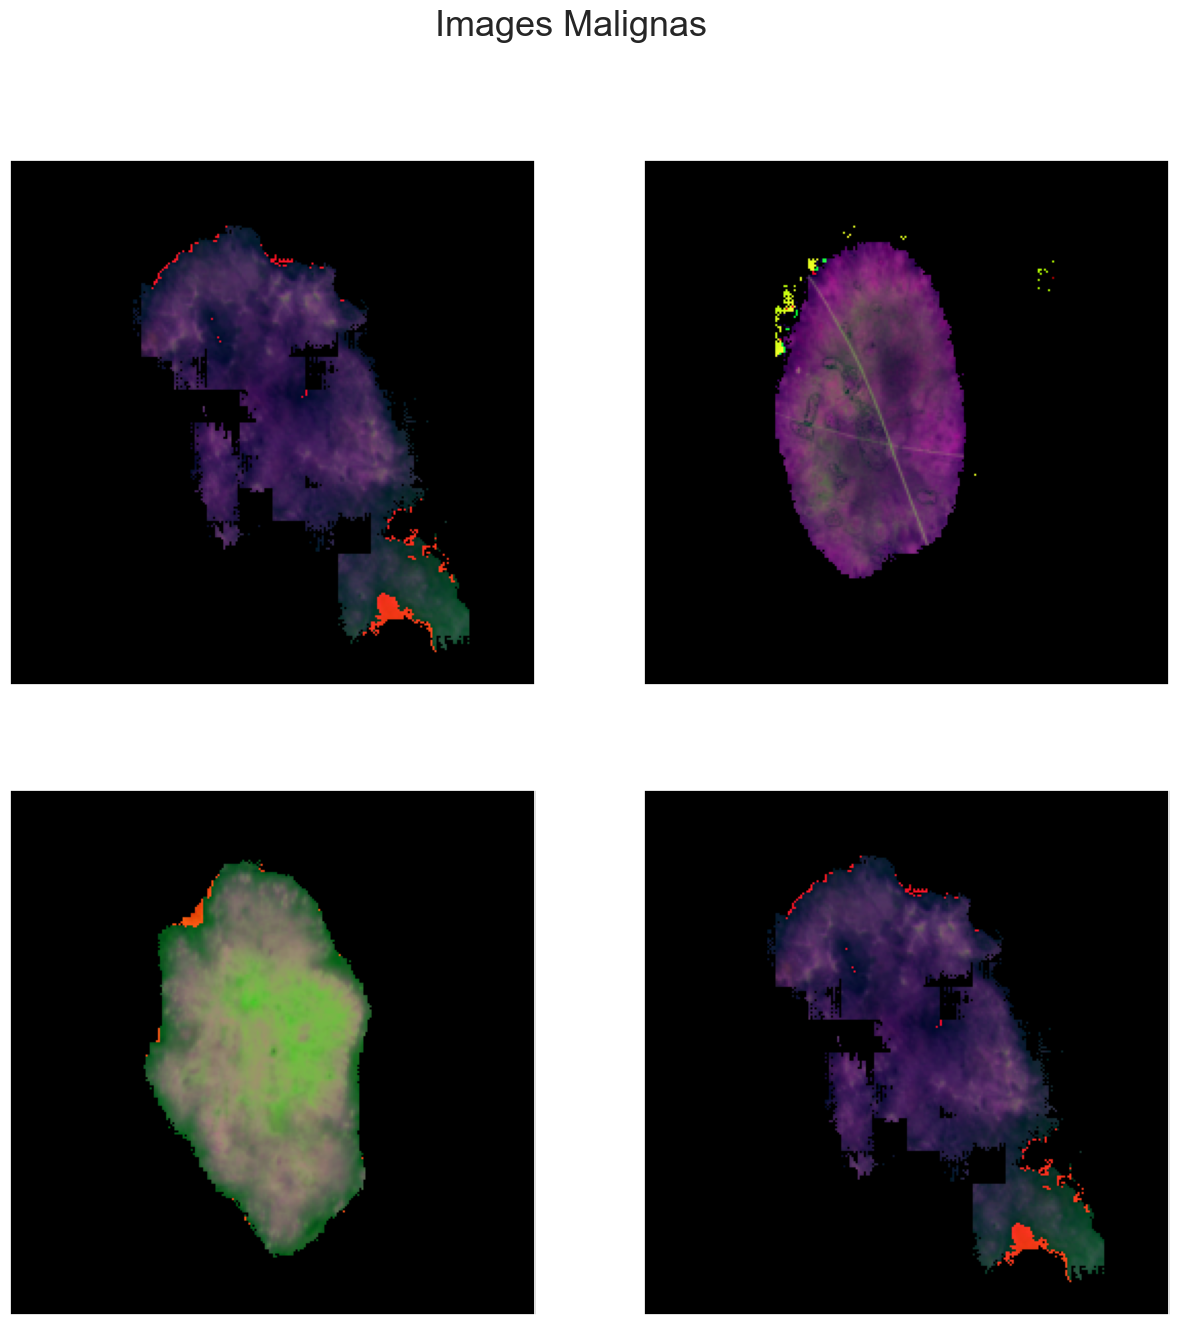

In [87]:
label = 'Malignas' #label for images with fire
data = df[df['label'] == label]

pics = 4 #set the number of pics
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Images Malignas')
ax = ax.ravel()
for i in range((pics//2)*2):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    img = image.load_img(path)
    img = image.img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

In [88]:
def shaper(row):
    shape = image.load_img(row['path']).size
    row['height'] = shape[1]
    row['width'] = shape[0]
    return row
df = df.apply(shaper,axis=1)
df.head(5)

,path,label,height,width
0,D:/Users/N30090/OneDrive - ArcelorMittal/Pictu...,Malignas,256,256
1,D:/Users/N30090/OneDrive - ArcelorMittal/Pictu...,Malignas,256,256
2,D:/Users/N30090/OneDrive - ArcelorMittal/Pictu...,Malignas,256,256
3,D:/Users/N30090/OneDrive - ArcelorMittal/Pictu...,Malignas,256,256
4,D:/Users/N30090/OneDrive - ArcelorMittal/Pictu...,Malignas,256,256


In [89]:
generator = ImageDataGenerator(
    rotation_range= 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 2,
    zoom_range=0.2,
    rescale = 1/255,
    validation_split=0.2,
)

In [90]:
train_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='training')
val_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='validation')

train, validate, test_gen = \
              np.split(df.sample(frac=1, random_state=42), 
                       [int(.6*len(df)), int(.8*len(df))])

Found 554 validated image filenames belonging to 2 classes.
Found 138 validated image filenames belonging to 2 classes.


In [91]:
class_indices = {}
for key in train_gen.class_indices.keys():
    class_indices[train_gen.class_indices[key]] = key
    
print(class_indices)

{0: 'Benignas', 1: 'Malignas'}


In [92]:
# Chamando a rede pré-treinada
conv_model = ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=(256,256,3))

first_freeze_layers = 20 #number of the first layers to freeze
for layer in conv_model.layers[0:first_freeze_layers]:
    layer.trainable = False

teste = keras.layers.Flatten()(conv_model.output)

# three hidden layers
teste = keras.layers.Dropout(0.4)(teste)
teste = keras.layers.Dense(128, activation='relu')(teste)
teste = keras.layers.Dense(64, activation='relu')(teste)

# final softmax layer with two categories
predictions = keras.layers.Dense(1, activation='sigmoid')(teste)

# creating the full model:
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)

full_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 64, 64, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 64, 64, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 64, 64, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 32, 32, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 32, 32, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 32, 32, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 16, 16, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 16, 16, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 16, 16, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 16, 16, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 16, 16, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 16, 16, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 16, 16, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 16, 16, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 8, 8, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 8, 8, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [93]:
#EARLY STOPPING ADICIONADO
# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=40,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True
)

lr_schedule = keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate = 0.01, 
    first_decay_steps = 500, 
    t_mul=2.4, 
    m_mul=1.3, 
    alpha=0.001, 
    name=None
)

In [94]:
# Compilando o modelo
full_model.compile(loss='binary_crossentropy',
                  optimizer= keras.optimizers.SGD(learning_rate=lr_schedule),
                  metrics=['accuracy','AUC'])

# Treinando o modelo com os dados de treino e teste
history = full_model.fit(x = train_gen,
                         batch_size=5,
                         epochs=25,
                         callbacks=[callback],
                         validation_data = val_gen
                        )

Epoch 1/25
18/18 [==============================] - 92s 5s/step - loss: 2.8946 - accuracy: 0.4946 - auc: 0.4962 - val_loss: 0.7029 - val_accuracy: 0.4420 - val_auc: 0.5271
Epoch 2/25
18/18 [==============================] - 83s 5s/step - loss: 0.7104 - accuracy: 0.4946 - auc: 0.4840 - val_loss: 0.6937 - val_accuracy: 0.4420 - val_auc: 0.4470
Epoch 3/25
18/18 [==============================] - 83s 5s/step - loss: 0.6946 - accuracy: 0.5144 - auc: 0.5167 - val_loss: 0.6938 - val_accuracy: 0.4855 - val_auc: 0.4351
Epoch 4/25
18/18 [==============================] - 85s 5s/step - loss: 0.6878 - accuracy: 0.5469 - auc: 0.5533 - val_loss: 0.6966 - val_accuracy: 0.4420 - val_auc: 0.5163
Epoch 5/25
18/18 [==============================] - 85s 5s/step - loss: 0.6757 - accuracy: 0.5686 - auc: 0.5922 - val_loss: 0.6984 - val_accuracy: 0.4493 - val_auc: 0.4701
Epoch 6/25
18/18 [==============================] - 86s 5s/step - loss: 0.6814 - accuracy: 0.6191 - auc: 0.6104 - val_loss: 0.6981 - val_acc

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])


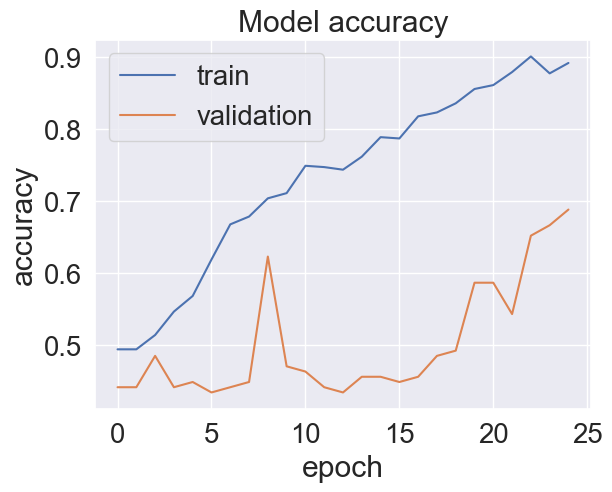

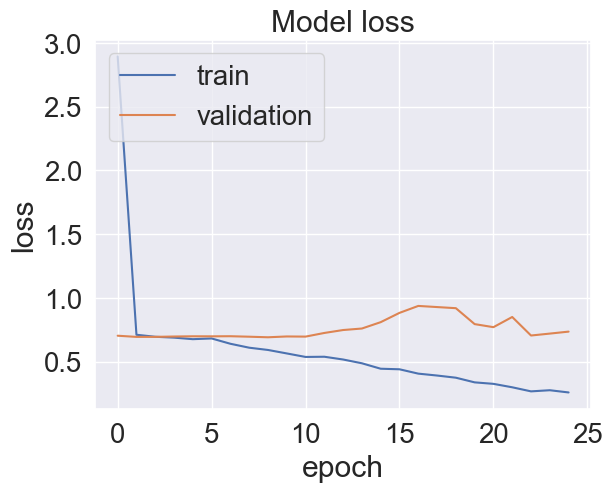

In [95]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [96]:
eval_list = full_model.evaluate(val_gen,return_dict=True)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")

5/5 [==============================] - 6s 1s/step - loss: 0.7418 - accuracy: 0.6449 - auc: 0.7473
loss: 0.74
accuracy: 0.64
auc: 0.75


In [97]:
#dados de teste
test_generator =  generator.flow_from_dataframe(test_gen, 
                                                   x_col='path',
                                                   y_col='label',
                                                   images_size=(256,256),
                                                   class_mode='binary',
                                                   subset='validation'
                                                  )

Found 27 validated image filenames belonging to 2 classes.


In [98]:
#Confution Matrix and Classification Report
Y_pred = full_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

1/1 [==============================] - 2s 2s/step


In [99]:
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix(test_generator.classes, y_pred )

array([[15,  0],
       [12,  0]], dtype=int64)

In [100]:
print(classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.56      1.00      0.71        15
           1       0.00      0.00      0.00        12

    accuracy                           0.56        27
   macro avg       0.28      0.50      0.36        27
weighted avg       0.31      0.56      0.40        27



Text(0.5, 10.124999999999995, 'Predicted label')

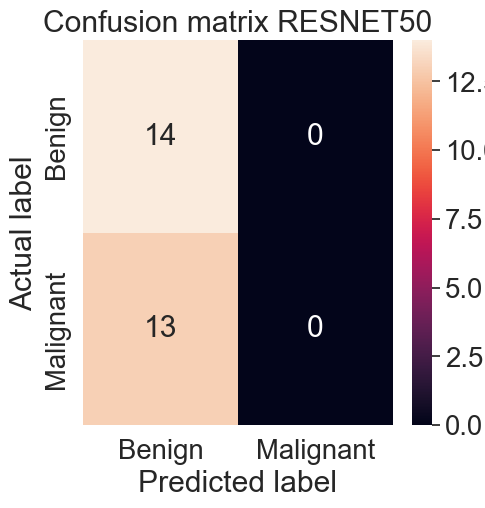

In [81]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

cm = confusion_matrix(test_generator.classes, y_pred)
#cm = [[24,11],[1,34]]
plt.figure(figsize=(5,5))
x_axis_labels = ['Benign','Malignant'] # labels for x-axis
y_axis_labels = ['Benign','Malignant'] # labels for y-axis
ax = sns.heatmap(cm, annot=True, fmt="d",xticklabels=x_axis_labels, yticklabels=y_axis_labels)
sns.set(font_scale=1.8)
plt.title('Confusion matrix RESNET50')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')